In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine,  text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import joblib
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn  
import xgboost as xgb
import os

C:\Users\dagim\anaconda3\envs\sdv-env\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
load_dotenv()  # load variables from .env

user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
database = os.getenv("POSTGRES_DB")

In [3]:
conn_str = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(conn_str)

In [4]:
query = text("SELECT * FROM claims")  

with engine.connect() as connection:
    df = pd.read_sql(query, con=connection)

df.head()

,claim_id,policy_start,incident_date,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score,days_to_incident
0,XAJI0Y6DP,2021-05-09,2021-12-17,551.74,WV,Truck,Weather Damage,Hailstorm caused significant roof and hood dam...,claimant,55174,47,1,0,0.01,222
1,BHSAHXTHV,2020-05-09,2020-05-29,62223.20,CO,Sedan,Weather Damage,V2 rear-ended V1 while stopped at a red light,claimant,95728,67,0,0,0.65,20
2,3A3ZMF8MD,2018-08-08,2019-08-08,15000.00,IN,Van,Head-on Collision,V2 crossed centerline and hit V1 head-on,insured,15000,50,3,0,1.00,365
3,D4V30T9NT,2019-12-30,2020-08-03,15805.40,KY,Sedan,Theft,V2 was behind V1 when it began backing up,insured,24316,75,1,0,0.65,217
4,3W5UZBIKC,2020-12-16,2021-07-19,88000.00,WA,Coupe,Side-impact,V2 ran a stop sign and hit the side of V1,insured,100000,34,5,0,0.88,215


In [7]:
df[df['fraud_flag'] != 1]

,claim_id,policy_start,incident_date,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score,days_to_incident
0,XAJI0Y6DP,2021-05-09,2021-12-17,551.74,WV,Truck,Weather Damage,Hailstorm caused significant roof and hood dam...,claimant,55174,47,1,0,0.01,222
1,BHSAHXTHV,2020-05-09,2020-05-29,62223.20,CO,Sedan,Weather Damage,V2 rear-ended V1 while stopped at a red light,claimant,95728,67,0,0,0.65,20
2,3A3ZMF8MD,2018-08-08,2019-08-08,15000.00,IN,Van,Head-on Collision,V2 crossed centerline and hit V1 head-on,insured,15000,50,3,0,1.00,365
3,D4V30T9NT,2019-12-30,2020-08-03,15805.40,KY,Sedan,Theft,V2 was behind V1 when it began backing up,insured,24316,75,1,0,0.65,217
4,3W5UZBIKC,2020-12-16,2021-07-19,88000.00,WA,Coupe,Side-impact,V2 ran a stop sign and hit the side of V1,insured,100000,34,5,0,0.88,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,K2C1S90NX,2019-02-10,2019-02-15,5850.00,ID,Van,Head-on Collision,V1 was reported stolen from insured’s driveway,insured,15000,76,1,0,0.39,5
9995,727OYAF9J,2020-06-03,2021-01-09,21122.97,UT,SUV,Side-impact,V1 was reported stolen from insured’s driveway,insured,91839,18,3,0,0.23,220
9996,SC17F0SGQ,2020-10-15,2021-07-30,77677.78,IN,Coupe,Side-impact,V1 was reported stolen from insured’s driveway,claimant,90323,49,1,0,0.86,288
9998,ETJ6UBRW9,2018-03-21,2018-10-22,8407.42,WA,Truck,Weather Damage,V2 rear-ended V1 while stopped at a red light,insured,18277,49,4,0,0.46,215


# Features and target

In [8]:
df_model = df.copy()

In [9]:
X = df_model.drop(columns=['fraud_flag', 'claim_id', 'severity_score', 'claim_amount', 'fact_of_loss', 'policy_start'])  # drop outputs
y = df_model['fraud_flag']

In [10]:
X['incident_month'] = X['incident_date'].dt.month
X['incident_dayofweek'] = X['incident_date'].dt.dayofweek
X = X.drop(columns=['incident_date'])

In [11]:
X.columns

Index(['state', 'vehicle_type', 'incident_type', 'reported_by', 'policy_limit',
       'insured_age', 'prior_claims_count', 'days_to_incident',
       'incident_month', 'incident_dayofweek'],
      dtype='object')

In [12]:
y.value_counts()

0    7954
1    2046
Name: fraud_flag, dtype: int64

In [13]:
categorical_cols = ['state', 'vehicle_type', 'incident_type', 'reported_by']

In [14]:
X[categorical_cols].dtypes

state            object
vehicle_type     object
incident_type    object
reported_by      object
dtype: object

In [15]:
#we drop the first category in each to avoid redundancy
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [48]:
#we drop the first category in each to avoid redundancy
r_encoded = pd.get_dummies(X, columns=categorical_cols)

In [62]:
print(r_encoded.shape)
r_encoded.head()

(10000, 52)


,policy_limit,insured_age,prior_claims_count,days_to_incident,incident_month,incident_dayofweek,state_AK,state_AL,state_AS,state_AZ,...,vehicle_type_Truck,vehicle_type_Van,incident_type_Backing Collision,incident_type_Head-on Collision,incident_type_Rear-end Collision,incident_type_Side-impact,incident_type_Theft,incident_type_Weather Damage,reported_by_claimant,reported_by_insured
0,55174,47,1,222,12,4,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
1,95728,67,0,20,5,4,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,15000,50,3,365,8,3,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
3,24316,75,1,217,8,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,100000,34,5,215,7,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [16]:
print(X_encoded.shape)
X_encoded.head()

(10000, 48)


,policy_limit,insured_age,prior_claims_count,days_to_incident,incident_month,incident_dayofweek,state_AL,state_AS,state_AZ,state_CO,...,vehicle_type_SUV,vehicle_type_Sedan,vehicle_type_Truck,vehicle_type_Van,incident_type_Head-on Collision,incident_type_Rear-end Collision,incident_type_Side-impact,incident_type_Theft,incident_type_Weather Damage,reported_by_insured
0,55174,47,1,222,12,4,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,95728,67,0,20,5,4,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,15000,50,3,365,8,3,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
3,24316,75,1,217,8,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,100000,34,5,215,7,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


# Split the Data Into Train/Test Sets

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

# Train the Model

In [58]:
model = XGBClassifier(
        n_estimators=100,        # Number of trees
        max_depth=5,             # Tree depth
        learning_rate=0.1,       # Shrinkage rate
        use_label_encoder=False, # Avoid warning
        eval_metric='logloss',   # Proper loss for binary classification
        random_state=42
)

In [59]:
model.fit(X_train, y_train)

C:\Users\dagim\anaconda3\envs\sdv-env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:59:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [60]:
y_pred = model.predict(X_test)

In [61]:
print(confusion_matrix(y_test, y_pred))

[[1589    2]
 [ 102  307]]


In [97]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.99      0.75      0.86       409

    accuracy                           0.95      2000
   macro avg       0.97      0.87      0.91      2000
weighted avg       0.95      0.95      0.95      2000



In [99]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.948


In [ ]:
"""
model correctly identified 1589 non-fraud claims

and caught 307 frauds

But missed 102 actual frauds 

Class 0 (Not Fraud):
- Precision: 0.94 → 94% of predicted non-fraud were correct
- Recall:    1.00 → You caught all non-fraud (almost no false positives)

Class 1 (Fraud):
- Precision: 0.99 → Nearly every time the model says "fraud", it’s correct
- Recall:    0.75 → Model caught 75% of actual frauds (missed 25%)
- F1-score:  0.86 → Strong balance between precision and recall

Overall Accuracy: **0.95 (95%)**

"""

# Improve Recall for Fraud 

In [102]:
y_proba = model.predict_proba(X_test)[:, 1]

In [104]:
for threshold in [0.5, 0.4, 0.3, 0.25]:
    y_pred = (y_proba >= threshold).astype(int)
    print(f"\nThreshold: {threshold}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


Threshold: 0.5
[[1589    2]
 [ 102  307]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.99      0.75      0.86       409

    accuracy                           0.95      2000
   macro avg       0.97      0.87      0.91      2000
weighted avg       0.95      0.95      0.95      2000


Threshold: 0.4
[[1585    6]
 [ 102  307]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.98      0.75      0.85       409

    accuracy                           0.95      2000
   macro avg       0.96      0.87      0.91      2000
weighted avg       0.95      0.95      0.94      2000


Threshold: 0.3
[[1561   30]
 [  99  310]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1591
           1       0.91      0.76      0.83       409

    accuracy                           0.94      2000

In [106]:
fraud_threshold = 0.3
y_pred_final = (y_proba >= fraud_threshold).astype(int)

In [116]:
#save model
joblib.dump(model, 'fraud_model_XGB.pkl')

['fraud_model_XGB.pkl']

In [45]:
joblib.dump(list(X_train.columns), "expected_model_columns.pkl")

['expected_model_columns.pkl']

In [120]:
#save Threshold 
with open("fraud_model_config.json", "w") as f:
    json.dump({"fraud_threshold": 0.3}, f)

# MLflow to log trained model and metrics 

In [138]:
# Input example 
input_example = X_test.iloc[:5]

# Log with input example and signature
mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path="xgboost_model",
    input_example=input_example,
    signature= mlflow.models.infer_signature(input_example, model.predict(input_example))
)

C:\Users\dagim\anaconda3\envs\sdv-env\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [144]:
mlflow.set_tracking_uri("file:///mnt/data/mlruns")

mlflow.set_experiment("fraud_detection_experiment")

with mlflow.start_run(run_name="xgboost_threshold_0.3"):
    model = XGBClassifier(
        n_estimators=100,        # Number of trees
        max_depth=5,             # Tree depth
        learning_rate=0.1,       # Shrinkage rate
        eval_metric='logloss',   # Proper loss for binary classification
        random_state=42)
    
    model.fit(X_train, y_train)
    
     # Predictions
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.3).astype(int)

    # Log hyperparams and threshold
    mlflow.log_param("model_type", "xgboost")
    mlflow.log_param("threshold", 0.3)
    mlflow.log_param("max_depth", 5)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("n_estimators", 100)

     # Log metrics
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))

    # Log the trained model
    mlflow.sklearn.log_model(model, artifact_path= "xgboost_model")

2025/05/20 16:00:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [146]:
mlflow.end_run()

In [39]:
def define_algorithms():
    return {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True)
    }
    
# Define hyperparameter spaces
def define_hyperparameter_spaces():
    return {
        'Logistic Regression': {
            'algorithm__C': [0.01, 0.1, 1, 10]
        },
        'Random Forest': {
            'algorithm__n_estimators': [100, 200],
            'algorithm__max_depth': [None, 5, 10],
        },
        'Decision Tree': {
            'algorithm__max_depth': [None, 5, 10],
            'algorithm__min_samples_split': [2, 5]
        },
        'SVM': {
            'algorithm__C': [0.1, 1, 10],
            'algorithm__kernel': ['linear', 'rbf']
        }
    }    
    
# Hyperparameter tuning
def perform_hyperparameter_tuning(X_train, y_train, algorithms, hyperparameter_spaces):
    best_params = {}
    for name, params in hyperparameter_spaces.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('algorithm', algorithms[name])
        ])
        grid = GridSearchCV(pipeline, params, cv=3, scoring='f1', n_jobs=-1)
        grid.fit(X_train, y_train)
        best_params[name] = grid.best_params_
        print(f"Best params for {name}: {grid.best_params_}")
    return best_params    

# Train models and log to MLflow
def train_and_log_models(X_train, y_train, X_test, y_test, algorithms, best_params, threshold=0.3):
    mlflow.set_tracking_uri("file:///mnt/data/mlruns")

    mlflow.set_experiment("fraud_detection_experiment")


    for name, model in algorithms.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('algorithm', model)
        ])
        pipeline.set_params(**best_params[name])
        pipeline.fit(X_train, y_train)

        y_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        with mlflow.start_run(run_name=name):
            # Log parameters (remove 'algorithm__' prefix)
            clean_params = {k.replace('algorithm__', ''): v for k, v in best_params[name].items()}
            mlflow.log_params(clean_params)
            mlflow.log_param("threshold", threshold)

            # Log metrics
            mlflow.log_metrics({
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            })

            # Log model
            mlflow.sklearn.log_model(
                    sk_model=pipeline,
                    artifact_path="model"
                )

            print(f"\n{name} Results:")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")
            print(confusion_matrix(y_test, y_pred))
            print(classification_report(y_test, y_pred))    
            
def cross_validate_models(X_train, y_train, algorithms, best_params):
    cv_results = {}
    for name, model in algorithms.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('algorithm', model)
        ])
        pipeline.set_params(**best_params[name])
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
        cv_results[name] = scores
        print(f"Cross-validation F1 scores for {name}: {scores}")            
    return cv_results

In [24]:
# Define algorithms and hyperparameter spaces
algorithms = define_algorithms()
hyperparameter_spaces = define_hyperparameter_spaces()

In [29]:
best_params = perform_hyperparameter_tuning(X_train, y_train, algorithms, hyperparameter_spaces)

Best params for Logistic Regression: {'algorithm__C': 10}
Best params for Random Forest: {'algorithm__max_depth': None, 'algorithm__n_estimators': 100}
Best params for Decision Tree: {'algorithm__max_depth': 5, 'algorithm__min_samples_split': 2}
Best params for SVM: {'algorithm__C': 10, 'algorithm__kernel': 'rbf'}


In [38]:
train_and_log_models(X_train, y_train, X_test, y_test, algorithms, best_params)

MLflow Run ID: 249f8edfa487415ba8580f8d746eea81


2025/05/27 14:19:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Logistic Regression Results:
Accuracy: 0.741
Precision: 0.436, Recall: 0.907, F1 Score: 0.589
[[1111  480]
 [  38  371]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1591
           1       0.44      0.91      0.59       409

    accuracy                           0.74      2000
   macro avg       0.70      0.80      0.70      2000
weighted avg       0.86      0.74      0.77      2000

MLflow Run ID: a00df4d3df7f4680bf0df9e4b6ac48c3


2025/05/27 14:19:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Random Forest Results:
Accuracy: 0.914
Precision: 0.801, Recall: 0.775, F1 Score: 0.788
[[1512   79]
 [  92  317]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1591
           1       0.80      0.78      0.79       409

    accuracy                           0.91      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.91      0.91      0.91      2000

MLflow Run ID: 453eaa0c1f3b4778bd3b738338749319


2025/05/27 14:19:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Decision Tree Results:
Accuracy: 0.948
Precision: 0.994, Recall: 0.751, F1 Score: 0.855
[[1589    2]
 [ 102  307]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1591
           1       0.99      0.75      0.86       409

    accuracy                           0.95      2000
   macro avg       0.97      0.87      0.91      2000
weighted avg       0.95      0.95      0.95      2000

MLflow Run ID: 19d829ea4062421baf445ceb1e7edea1


2025/05/27 14:19:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



SVM Results:
Accuracy: 0.846
Precision: 0.604, Recall: 0.711, F1 Score: 0.653
[[1400  191]
 [ 118  291]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1591
           1       0.60      0.71      0.65       409

    accuracy                           0.85      2000
   macro avg       0.76      0.80      0.78      2000
weighted avg       0.86      0.85      0.85      2000



In [40]:
cv_result = cross_validate_models(X_train, y_train, algorithms, best_params)

Cross-validation F1 scores for Logistic Regression: [0.65149701 0.64903846 0.63970588 0.6635183  0.67073171]
Cross-validation F1 scores for Random Forest: [0.83333333 0.82978723 0.81374322 0.85714286 0.84210526]
Cross-validation F1 scores for Decision Tree: [0.83098592 0.8342246  0.81521739 0.85565217 0.84507042]
Cross-validation F1 scores for SVM: [0.68617886 0.68135593 0.65180103 0.68932039 0.69421488]


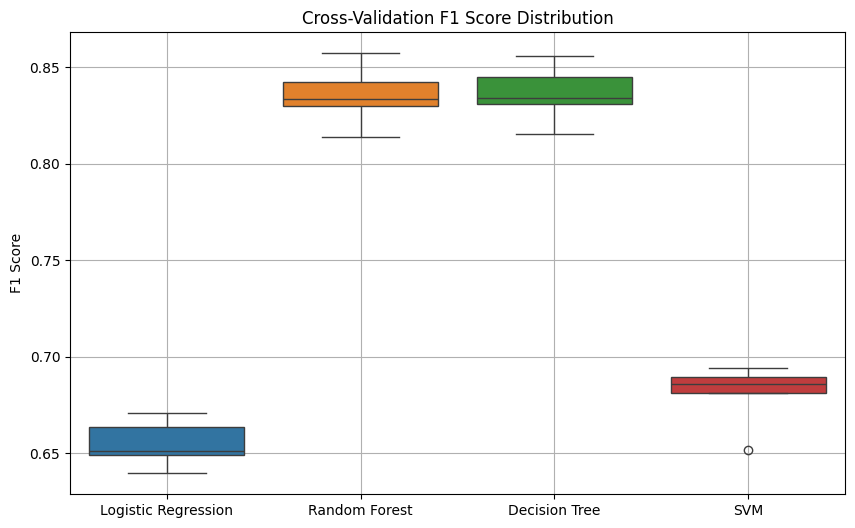

In [43]:
import seaborn as sns

cv_df = pd.DataFrame(cv_result)
plt.figure(figsize=(10, 6))
sns.boxplot(data=cv_df)
plt.title("Cross-Validation F1 Score Distribution")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()